## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [28]:
import Pkg
Pkg.activate(".")

  Activating project at `d:\Git_Repos\Julia\BME-502-2025-homeworks`


In [ ]:
Pkg.add(["Plots","Distributions","Random","Statistics","NonlinearSolve","ForwardDiff"])

   Resolving package versions...
    Updating `D:\Git_Repos\Julia\BME-502-2025-homeworks\Project.toml`
  [f27b6e38] + Polynomials v4.0.19
    Updating `D:\Git_Repos\Julia\BME-502-2025-homeworks\Manifest.toml`
  [f27b6e38] + Polynomials v4.0.19


In [ ]:
using Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra

In [31]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [32]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [33]:
x = 0:0.1:10

0.0:0.1:10.0

In [34]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [35]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

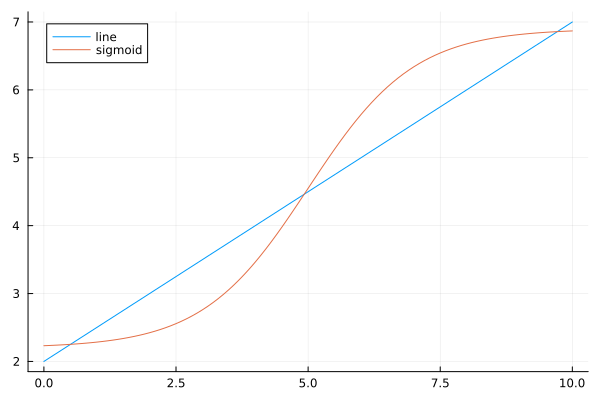

In [36]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [37]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
  2.704227999193372
  0.13868544589638576
 13.289896511138277
  0.07712111989704384
  3.336025498150914
  0.8146044418650575
  5.91342678215937
 -0.14064868742878556
  9.42660417973038
 -0.7039167798865438
  ⋮
  4.270778344240237
  4.3300536896001605
  3.1295946615828427
  3.8845484163442943
 -2.754698755974938
  8.660190378709657
 -3.8712294592191374
  2.114540026272536
 -2.3666478030389726

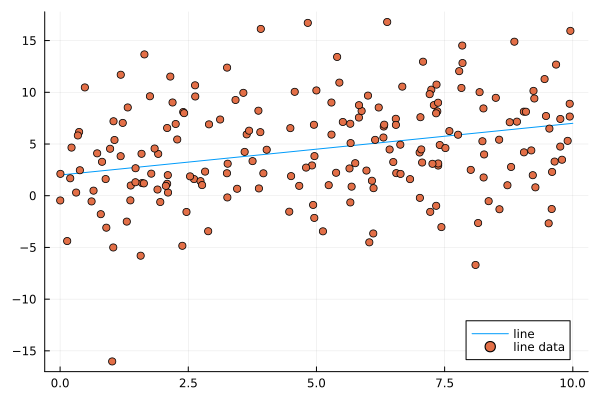

In [38]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

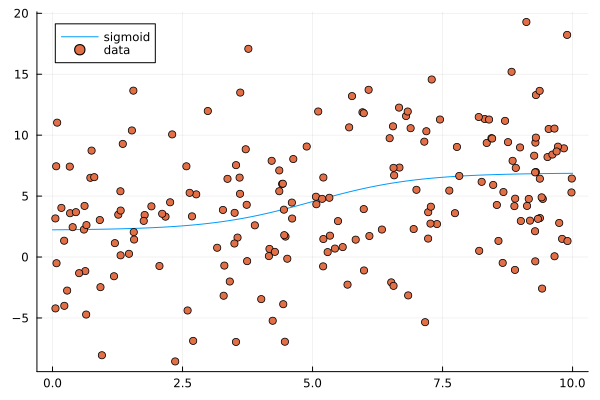

In [39]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

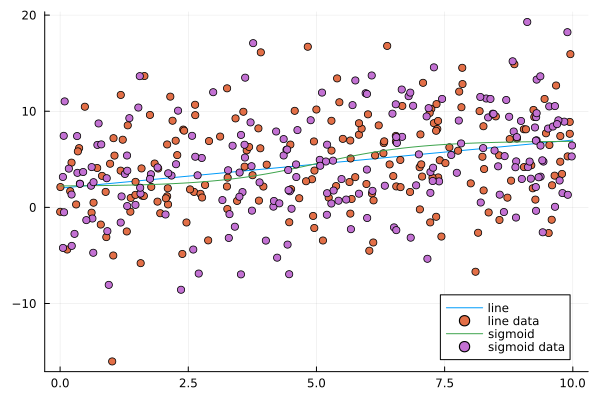

In [40]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [ ]:
function lsqfitting(fitfct, (x,y), sigma, β0) #borrowed from Model Selection class
    res(β,(x,y)) = fitfct(x,β) .- y
    prob = NonlinearLeastSquaresProblem(res, β0, (x,y))
    sol = solve(prob, GaussNewton(); maxiters =1000)
    if sigma == nothing
        return sol.u
    else
        chi2(β) = sum(abs2, res(β,(x,y)) ./ sigma)
        return sol.u, inv(2*ForwardDiff.hessian(chi2,sol.u)), chi2(sol.u)
    end
end

lineareq(x,β) = β[1] .+ β[2] .* x

function line_fitting(x,y;σ=[])
    #returns best parameters, covariance matrix
        
    if σ == []
        # print("It's working")
        linbeta = lsqfitting(lineareq, (x,y), nothing, [1,1]) #initial guess chosen arbitrarily
        
        res(u, (x,y))= u[1] .* exp.(u[2] .* x) .- y
        chi2(u,(x,y)) = sum(res(u,(x,y)) .^2 ./ 0.1^2)
        ourchi2(u) = chi2(u,(x,y))

        h = ForwardDiff.hessian(ourchi2,linbeta)
        invmat = inv(2*h) #something is clearly wrong bcs the signs are the reverse of what I'd expect
        lincov = sqrt.(-invmat[diagind(invmat)]) #Unclear why these values are initially negative
        #estimate w/ sum of least squares
    else #should work for either scalar or vector                                      
        linbeta, lincov, linchi2best = lsqfitting(lineareq, (x,y), σ, [1,1]) #initial guess chosen arbitrarily
    end

    return linbeta,lincov
end

In [ ]:
line_fitting(x_line,y_line_n,σ=4) #this is clearly wrong

In [ ]:
# function lsqfitting(fitfct, (x,y) , sigma, β0)
#     res(β,(x,y)) = fitfct(x,β) .- y
#     prob = NonlinearLeastSquaresProblem(res, β0, (x,y))
#     sol = solve(prob, GaussNewton(); maxiters =1000)
#     chi2(β) = sum(abs2, res(β,(x,y)) ./ sigma)
#     return sol.u, inv(2*ForwardDiff.hessian(chi2,sol.u)), chi2(sol.u)
# end
# lineareq(x,β) = β[1] .+ β[2] .* x

# linbeta, lincov, linchi2best = lsqfitting(lineareq, (x_line,y_line_n), 5, [0.8,2.5])


([0.8, 2.5], [0.12427868272149746 -0.018357251242607876; -0.018357251242607876 0.0036224169076227884], 1123.1813058134085)

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [57]:
sigmoideq(x,β) = β[1] .+ β[2] ./ (1 .+ exp.(-β[3]*(x .- β[4])))

function sigmoid_fitting(x,y;σ=[])
    #returns best parameters, covariance matrix
        
    if σ == []
        # print("It's working")
        sigbeta = lsqfitting(sigmoideq, (x,y), nothing, [1,1,1,1]) #initial guess chosen arbitrarily
        
        res(u, (x,y))= u[1] .* exp.(u[2] .* x) .- y
        chi2(u,(x,y)) = sum(res(u,(x,y)) .^2 ./ 0.1^2)
        ourchi2(u) = chi2(u,(x,y))

        h = ForwardDiff.hessian(ourchi2,sigbeta)
        invmat = inv(2*h) #something is clearly wrong bcs the signs are the reverse of what I'd expect
        sigcov = sqrt.(-invmat[diagind(invmat)]) #Unclear why these values are initially negative
        #estimate w/ sum of least squares
    else #should work for either scalar or vector                                      
        sigbeta, sigcov, sigchi2best = lsqfitting(sigmoideq, (x,y), σ, [1,1,1,1]) #initial guess chosen arbitrarily
    end

    return sigbeta,sigcov
end

sigmoid_fitting (generic function with 1 method)

In [58]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n,σ=4) #this is clearly wrong

([1.0, 1.0, 1.0, 1.0], [-0.05912312564262863 0.07425140318569655 0.02452650759045011 -0.20191125316498887; 0.07425140318569656 -0.06678149379209922 -0.027063559536661785 0.22417631058868126; 0.024526507590450115 -0.02706355953666179 0.07540276488189328 0.06327333245876801; -0.20191125316498884 0.22417631058868118 0.06327333245876797 -0.06863682501369306])

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.